In [623]:
#needed libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

import xgboost as xgb
import category_encoders as ce

In [584]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, roc_auc='skip'):
    '''
    orginial function at : 
    (https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb)
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    
    roc_auc allows you to set how to calculate the roc_auc score: 
    'dec' for decision_function or 'proba' for predict_proba 
    If roc_auc == 'skip', then it ignores calculating the roc_auc_score
    
    Inputs:
        estimator: a fit sklearn-style model or pipeline
        X_tr: array or pandas dataframe
            training input variables
        X_te: array or pandas dataframe
            testing input variables
        y_tr: array or pandas series
            training output variable
        y_te: array or pandas series
            testing output variable
        roc_auc: str
            'skip': default, skips calculating roc_auc
            'dec': use decision_function to calculate roc_auc
            'proba': use predict_proba to calculate roc_auc
            
    '''
    # Grab predictions
    tr_preds = estimator.predict(X_tr)
    te_preds = estimator.predict(X_te)
    
    # output needed for roc_auc_score
    if roc_auc == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec': 
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif roc_auc == 'proba': 
        train_out = estimator.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec' or 'proba'")    
    
    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train Precision: {precision_score(y_tr, tr_preds)}")
    print(f"Train Recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train F1-Score: {f1_score(y_tr, tr_preds)}")
    if type(train_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
        
    print("*" * 10)
    print("Testing Scores:")
    print(f"Test Accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test Precision: {precision_score(y_te, te_preds)}")
    print(f"Test Recall: {recall_score(y_te, te_preds)}")
    print(f"Test F1-Score: {f1_score(y_te, te_preds)}")
    if type(test_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")    
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(estimator, X_te, y_te, values_format='.5g', cmap=plt.cm.Oranges)

In [585]:
!pip install category_encoders

In [586]:
#pulling our pickled dataframe from EDA notebook
df = pd.read_pickle("../../data/model.pkl")
df

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total_domestic_minutes,total_domestic_calls,total_domestic_charge,total_charge,churn_rate
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,...,10.0,3,2.70,1,0,707.2,300,72.86,75.56,med
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,...,13.7,3,3.70,1,0,611.5,329,55.54,59.24,med-low
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,...,12.2,5,3.29,0,0,527.2,328,59.00,62.29,high
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,...,6.6,7,1.78,2,0,558.2,248,65.02,66.80,med-low
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,...,10.1,3,2.73,3,0,501.9,356,49.36,52.09,med-low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,no,yes,36,156.2,77,26.55,215.5,126,...,9.9,6,2.67,2,0,650.8,286,57.43,60.10,low
3329,WV,68,no,no,0,231.1,57,39.29,153.4,55,...,9.6,4,2.59,3,0,575.8,235,60.94,63.53,low
3330,RI,28,no,no,0,180.8,109,30.74,288.8,58,...,14.1,6,3.81,2,0,661.5,258,63.93,67.74,low
3331,CT,184,yes,no,0,213.8,105,36.35,159.6,84,...,5.0,10,1.35,2,0,512.6,326,56.18,57.53,med


## Model-less evaluation

In [587]:
df["churn"].value_counts(normalize=True)

0    0.855086
1    0.144914
Name: churn, dtype: float64

The model would only be right 14.5% of the time if the model only guessed every customer would leave.

As we devlop our models, we will be optomizing the recall score of our models. Our strategies We may identify more people as leaving, but in reality they stay. The company will spend some resources to retain the customer. However, that the cost of keeping them engaged with the company far outweighs the cost of identifying someone as staying and in actuality they leave the company. The company would lose a customer and then have to spend more resources to get a new customer in their place.

## Baseline Model

In [588]:
from sklearn.model_selection import train_test_split

X = df.drop(["churn"], axis = 1)
y= df["churn"]
seed = 42

#holds 10% of my data for final evaluation.
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.25, random_state=seed)

#uses the remaining data and splits the data into test and train data to use while finding best model.
X_train, X_test, y_train, y_test = train_test_split(X_use, y_use, test_size=0.1, random_state=seed)

In [589]:
#describe numerical columns
X_train.describe()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,total_domestic_minutes,total_domestic_calls,total_domestic_charge,total_charge
count,2249.00000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000
mean,100.63984,7.992441,179.737928,100.398399,30.555936,200.459849,99.876834,17.039311,200.883948,99.869720,9.039809,10.256025,4.459760,2.769644,1.570031,581.081725,300.144953,56.635056,59.404700
std,39.42390,13.699834,54.402345,20.044113,9.248380,50.656424,20.049082,4.305806,50.604299,19.471816,2.277188,2.783890,2.430585,0.751679,1.331460,89.745352,34.261871,10.459522,10.465262
min,1.00000,0.000000,2.600000,30.000000,0.440000,0.000000,0.000000,0.000000,45.000000,33.000000,2.030000,0.000000,0.000000,0.000000,0.000000,275.200000,188.000000,19.980000,23.250000
25%,73.00000,0.000000,143.600000,88.000000,24.410000,166.400000,87.000000,14.140000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,522.300000,277.000000,49.570000,52.440000
50%,100.00000,0.000000,179.200000,101.000000,30.460000,201.000000,100.000000,17.090000,201.400000,100.000000,9.060000,10.300000,4.000000,2.780000,1.000000,582.700000,300.000000,56.640000,59.420000
75%,127.00000,19.000000,216.600000,114.000000,36.820000,233.300000,113.000000,19.830000,235.800000,113.000000,10.610000,12.000000,6.000000,3.240000,2.000000,641.200000,323.000000,63.440000,66.300000
max,232.00000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,18.000000,5.400000,9.000000,871.700000,407.000000,92.560000,96.150000


In [590]:
#no nulls or missing values
X_train.isna().sum()

state                     0
account length            0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
total_domestic_minutes    0
total_domestic_calls      0
total_domestic_charge     0
total_charge              0
churn_rate                0
dtype: int64

In [591]:
#look at object columns
X_train[[c for c in X_train.columns if X_train[c].dtype == 'object']].describe()

,state,international plan,voice mail plan,churn_rate
count,2249,2249,2249,2249
unique,51,2,2,4
top,MN,no,no,med-low
freq,64,2031,1640,731


In [592]:
#looking at churn distribution in training set
y_train.value_counts(normalize=True)

0    0.856825
1    0.143175
Name: churn, dtype: float64

## Logistic Regression

In [593]:
X_train_state = X_train[["state"]]
X_test_state = X_test[["state"]]


ohe = OneHotEncoder(categories="auto", sparse=False)
state_ohe_train = ohe.fit_transform(X_train_state)
state_ohe_test = ohe.transform(X_test_state)


X_train_state = pd.DataFrame(state_ohe_train, columns=ohe.categories_[0],index= X_train.index)
X_test_state = pd.DataFrame(state_ohe_test, columns=ohe.categories_[0],index= X_test.index)


X_train = pd.concat([X_train, X_train_state], axis=1)
X_test = pd.concat([X_test, X_test_state], axis=1)

X_train = X_train.drop("state", axis = 1)
X_test = X_test.drop("state", axis = 1)

In [594]:
X_train_churn_rate = X_train[["churn_rate"]]
X_test_churn_rate = X_test[["churn_rate"]]

churn_rate_ohe_train = ohe.fit_transform(X_train_churn_rate)
churn_rate_ohe_test = ohe.transform(X_test_churn_rate)

X_train_churn_rate = pd.DataFrame(churn_rate_ohe_train, columns=ohe.categories_[0],index= X_train.index)
X_test_churn_rate = pd.DataFrame(churn_rate_ohe_test, columns=ohe.categories_[0],index= X_test.index)

X_train = pd.concat([X_train, X_train_churn_rate], axis=1)
X_test = pd.concat([X_test, X_test_churn_rate], axis=1)

X_train = X_train.drop("churn_rate", axis = 1)
X_test = X_test.drop("churn_rate", axis = 1)

In [595]:
X_train_international_plan = X_train[["international plan"]]
X_test_international_plan = X_test[["international plan"]]

international_plan_ohe_train = ohe.fit_transform(X_train_international_plan)
international_plan_ohe_test = ohe.transform(X_test_international_plan)

X_train_international_plan = pd.DataFrame(international_plan_ohe_train, columns=ohe.categories_[0],index= X_train.index)
X_test_international_plan = pd.DataFrame(international_plan_ohe_test, columns=ohe.categories_[0],index= X_test.index)

X_train = pd.concat([X_train, X_train_international_plan], axis=1)
X_test = pd.concat([X_test, X_test_international_plan ], axis=1)

X_train = X_train.drop("international plan", axis = 1)
X_test = X_test.drop("international plan", axis = 1)

In [596]:
X_train_voice_mail_plan = X_train[["voice mail plan"]]
X_test_voice_mail_plan = X_test[["voice mail plan"]]

voice_mail_plan_ohe_train = ohe.fit_transform(X_train_voice_mail_plan)
voice_mail_plan_ohe_test = ohe.transform(X_test_voice_mail_plan)

X_train_voice_mail_plan = pd.DataFrame(voice_mail_plan_ohe_train, columns=ohe.categories_[0],index= X_train.index)
X_test_voice_mail_plan = pd.DataFrame(voice_mail_plan_ohe_test, columns=ohe.categories_[0],index= X_test.index)

X_train = pd.concat([X_train, X_train_voice_mail_plan], axis=1)
X_test = pd.concat([X_test, X_test_voice_mail_plan], axis=1)

X_train = X_train.drop("voice mail plan", axis = 1)
X_test = X_test.drop("voice mail plan", axis = 1)

In [597]:
X_train

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,...,WV,WY,high,low,med,med-low,no,yes,no,yes
2956,112,0,81.6,94,13.87,268.1,112,22.79,140.8,75,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1737,134,0,141.7,95,24.09,205.6,101,17.48,218.5,60,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
336,99,0,169.2,70,28.76,271.5,77,23.08,170.2,104,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
159,115,24,142.1,124,24.16,183.4,129,15.59,164.8,114,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2009,82,0,130.0,110,22.10,185.3,88,15.75,178.7,105,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,176,0,47.4,125,8.06,167.8,90,14.26,163.1,107,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
738,68,0,159.5,123,27.12,240.8,93,20.47,210.3,76,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
236,110,40,202.6,103,34.44,118.8,128,10.10,234.9,98,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [598]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

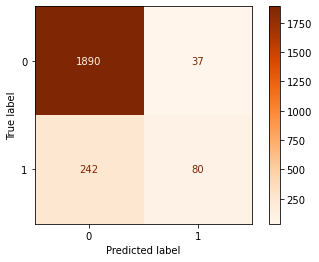

In [599]:
logreg = LogisticRegression(random_state=seed, max_iter = 1e4)

model = logreg.fit(X_train_scaled, y_train)
plot_confusion_matrix(model, X_train_scaled, y_train, cmap=plt.cm.Oranges)

In [600]:
cv = cross_validate(model, X_train_scaled, y_train, scoring=["accuracy", "recall"])

print(f"Average Accuracy: {cv['test_accuracy'].mean()} +/- {cv['test_accuracy'].std()}")
print(f"Average Recall: {cv['test_recall'].mean()} +/- {cv['test_recall'].std()}")

Average Accuracy: 0.8661658005444195 +/- 0.008549083880330235
Average Recall: 0.205 +/- 0.015541864631150851


## First Model - Decision Tree

In [601]:

X = df.drop("churn", axis = 1)
y= df["churn"]
seed = 42

#holds 10% of my data for final evaluation.
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.25, random_state=seed)

#uses the remaining data and splits the data into test and train data to use while finding best model.
X_train, X_test, y_train, y_test = train_test_split(X_use, y_use, test_size=0.1, random_state=seed)

In [602]:
X_train.shape

(2249, 23)

In [603]:
# organize columns for the pipeline
num_cols = []
ohe_cols = []
freq_cols = []

for c in X_train.columns:
    if X_train[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X_train[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [604]:
print(num_cols)
print(ohe_cols)
print(freq_cols)

['account length', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls', 'total_domestic_minutes', 'total_domestic_calls', 'total_domestic_charge', 'total_charge']
['international plan', 'voice mail plan', 'churn_rate']
['state']


In [605]:
nums = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median'))
    ])

ohe = Pipeline(steps=[
    ("ohe_encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

freq = Pipeline(steps=[
    ("freq_encoder", ce.count.CountEncoder(normalize=True, min_group_size=.01))
    ])

In [606]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", nums, num_cols),
        ("ohe", ohe, ohe_cols),
        ("freq", freq, freq_cols)
    ])

In [607]:
preprocess.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['account length', 'number vmail messages',
                                  'total day minutes', 'total day calls',
                                  'total day charge', 'total eve minutes',
                                  'total eve calls', 'total eve charge',
                                  'total night minutes', 'total night calls',
                                  'total night charge', 'total intl minutes',
                                  'total intl calls', 'total intl...
                                  'total_domestic_minutes',
                                  'total_domestic_calls',
                                  'total_domestic_charge', 'total_charge']),
                                ('ohe',
                                 Pipeline(steps=[

In [608]:
dt = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', DecisionTreeClassifier(random_state=seed))
])

In [609]:
dt.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
         

In [610]:
y_preds = dt.predict(X_test)

Recall score for Model Before Tuning
0.8055555555555556
Confusion Matrix for Model Before Tuning


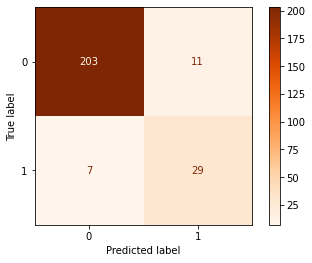

In [611]:
print('Recall score for Model Before Tuning')
print(recall_score(y_test, y_preds))
print('Confusion Matrix for Model Before Tuning')
plot_confusion_matrix(dt, X_test, y_test, cmap=plt.cm.Oranges)

In [612]:
cross_validate(dt, X_train, y_train, return_train_score=True)

{'fit_time': array([0.10201335, 0.10828447, 0.0860064 , 0.07700467, 0.0990591 ]),
 'score_time': array([0.01599336, 0.01400137, 0.01400232, 0.01100183, 0.01900578]),
 'test_score': array([0.92666667, 0.94222222, 0.94      , 0.94      , 0.93986637]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [618]:
param_grid = {
    "classifier__max_depth": [5,10,15,20],
    "classifier__min_samples_split": [2, 6,7,8],
    "classifier__min_samples_leaf": [2, 4,5,6,],
    "classifier__max_features" : [15, 20,23]
}

In [619]:
grid = GridSearchCV(dt, param_grid)

In [620]:
output = grid.fit(X_train, y_train)

In [621]:
output.best_params_

{'classifier__max_depth': 5,
 'classifier__max_features': 23,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 2}

Training Scores:
Train Accuracy: 0.9764339706536238
Train Precision: 0.996309963099631
Train Recall: 0.8385093167701864
Train F1-Score: 0.9106239460370995
ROC-AUC: 0.9418439179105681
**********
Testing Scores:
Test Accuracy: 0.968
Test Precision: 0.9666666666666667
Test Recall: 0.8055555555555556
Test F1-Score: 0.8787878787878789
ROC-AUC: 0.8801272066458983


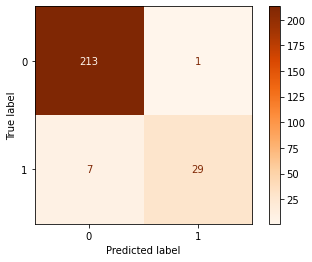

In [622]:
evaluate(output.best_estimator_, X_train, X_test, y_train, y_test, roc_auc='proba')

In [624]:
knn = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', KNeighborsClassifier())
])

In [625]:
cross_validate(knn, X_train, y_train, return_train_score=True)

{'fit_time': array([0.03700209, 0.03700376, 0.03600502, 0.04800439, 0.06599665]),
 'score_time': array([0.08416033, 0.08087635, 0.07755232, 0.09516644, 0.11000752]),
 'test_score': array([0.66222222, 0.66444444, 0.62888889, 0.67333333, 0.67706013]),
 'train_score': array([0.81878822, 0.81767649, 0.82045581, 0.81767649, 0.82166667])}

In [633]:
param_grid = {
    'classifier__n_neighbors': [5, 15, 25, 35, 45, 55, 65],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2, 10]
}

In [634]:
grid = GridSearchCV(knn, param_grid)

In [635]:
output = grid.fit(X_train, y_train)

In [636]:
output.best_params_

{'classifier__n_neighbors': 65,
 'classifier__p': 1,
 'classifier__weights': 'distance'}

Training Scores:
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1-Score: 1.0
ROC-AUC: 1.0
**********
Testing Scores:
Test Accuracy: 0.716
Test Precision: 0.2839506172839506
Test Recall: 0.6388888888888888
Test F1-Score: 0.39316239316239315
ROC-AUC: 0.7427310488058152


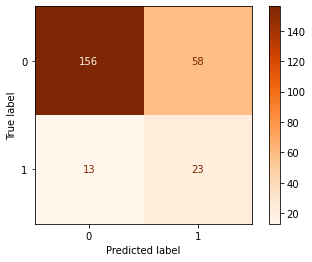

In [637]:
evaluate(output.best_estimator_, X_train, X_test, y_train, y_test, roc_auc='proba')